<a href="https://colab.research.google.com/github/ifatima95/Arabic_NLP/blob/main/Test_sentiment_topic_classification_model_all_bagging_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re

import tensorflow as tf
import keras.backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils #to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import Embedding, LSTM, Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# ML Baseline
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB

from sklearn.ensemble import BaggingClassifier

from sklearn.metrics import f1_score

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords as stop

import joblib

## Data Wrangling

In [ ]:
PATH = '/content/Sentiments_and_Topics .csv' # CHANGE THIS
tweets = pd.read_csv(PATH)
tweets.head()

,Tweet_id,Text,sentiment(Target),Topic (Target)
0,1221875106206638080,@nas_alharbi8 والله حسب الأرقام سيكون مخيب للآ...,Positive,politics
1,1221884257490042887,"""الزعل بيغير ملامحك ، بيغير نظرة العين ، بيغير...",Neutral,Health
2,1226422627436310528,الحب الحقيقي هو اقتسام بعض نفسك مع شخص أخر أقر...,Positive,Health
3,1221880820815798277,@Mo_Fat7 النهضة في فتيل 😂,Positive,politics
4,1221884400377499651,@halgawi @DmfMohe ليس حباً في ايران بقدر ماهو ...,Neutral,politics


In [ ]:
print("Data Size:", tweets.shape)

Data Size: (32763, 4)


## Data Cleaning

In [ ]:
# see if exist nan values
tweets.isna().sum()

Tweet_id             1
Text                 1
sentiment(Target)    2
Topic (Target)       3
dtype: int64

In [ ]:
# drop nan values
tweets.dropna(axis=0, inplace=True)

print("Data Size after drop nan values:", tweets.shape)

Data Size after drop nan values: (32760, 4)


In [ ]:
# show sample text
tweets['Text'][0]

'@nas_alharbi8 والله حسب الأرقام سيكون مخيب للآمال\r\nولكن الأهلي قدها برجاله في الملعب 💚🤍'

In [ ]:
def cleaner(tweet):
    #tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub("@[^\s]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    return tweet

#tweets['Text'] = tweets['Text'].map(lambda x: cleaner(x))

### Stop Word

In [ ]:
nltk.download('stopwords')
sw = stop.words('arabic')

def stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    tokenizer = TweetTokenizer()
    text = [word.lower() for word in tokenizer.tokenize(text) if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
tweets['Text'] = tweets['Text'].apply(stopwords)
tweets['Text'][0]

'@nas_alharbi8 والله الأرقام سيكون مخيب للآمال الأهلي قدها برجاله الملعب 💚 🤍'

### Remove Punctuation

In [ ]:
def remove_punctuation(text):
    '''a function for removing punctuation'''
    text = str(text)
    import string
    # replacing the punctuations with no space,
    # which in effect deletes the punctuation marks
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)

In [ ]:
tweets['Text'] = tweets['Text'].apply(remove_punctuation)
tweets['Text'][0]

'nasalharbi8 والله الأرقام سيكون مخيب للآمال الأهلي قدها برجاله الملعب 💚 🤍'

In [ ]:
def remove_emojis(data):
    data = str(data)
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data).strip()

In [ ]:
tweets['Text'] = tweets['Text'].apply(remove_emojis)
tweets['Text'][0]

'nasalharbi8 والله الأرقام سيكون مخيب للآمال الأهلي قدها برجاله الملعب'

In [ ]:
train, test = train_test_split(tweets, random_state=42, test_size=0.2)

# **1. Topic (Target)**

## Text Processing

In [ ]:
MAX_FEATURES = 2048
MAX_TEXT_LENGTH = 1024
MAX_LENGTH = 512

In [ ]:
train_text = train['Text']
test_text = test['Text']

In [ ]:
# tokenize the sentences
tokenizer = Tokenizer(lower=False, num_words=MAX_TEXT_LENGTH)
tokenizer.fit_on_texts(train_text)

train_text_seq = tokenizer.texts_to_sequences(train_text)
test_text_seq = tokenizer.texts_to_sequences(test_text)

# pad the sequences
train_text_vec = pad_sequences(train_text_seq, maxlen=MAX_LENGTH)
test_text_vec = pad_sequences(test_text_seq, maxlen=MAX_LENGTH)

In [ ]:
train_vec = tokenizer.sequences_to_matrix(train_text_seq, mode='count')
test_vec = tokenizer.sequences_to_matrix(test_text_seq, mode='count')

In [ ]:
print('Number of Tokens:', len(tokenizer.word_index))
print("Max Token Index:", train_text_vec.max(), "\n")

Number of Tokens: 78277
Max Token Index: 1023 



### Label Processing

In [ ]:
target_col = 'Topic (Target)'

tweets[target_col].unique()

array(['politics', 'Health', 'Politics', 'business ', 'Business',
       'Business-and-economy', 'Business '], dtype=object)

In [ ]:
def edit_target(text):
    if text.lower().startswith('p'):
        return "Politics"
    elif text.lower().startswith('b'):
        return "Business"
    else:
        return "Health"

In [ ]:
train.loc[:, target_col] = train.loc[:, target_col].apply(edit_target)
test.loc[:, target_col] = test.loc[:, target_col].apply(edit_target)

classes = sorted(train[target_col].unique())
n_classes = len(classes)

classes

['Business', 'Health', 'Politics']

In [ ]:
# One Hot Encode Y values:
le = LabelEncoder()

y_train = le.fit_transform(train[target_col].values)
y_test = le.transform(test[target_col].values)

y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)

In [ ]:
def f1_scores(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## 1.1 LSTM

In [ ]:
def lstm_model(EMBED_SIZE=128, MAX_LENGTH=MAX_LENGTH):
    inputs = Input(shape=(MAX_LENGTH,))

    x = Embedding(input_dim = (len(tokenizer.word_counts) + 1),
                  output_dim = 128,)(inputs)

    x = LSTM(units=256, return_sequences=True, return_state=False)(x)
    x = Dropout(0.25)(x)

    x = LSTM(units=128, return_sequences=True)(x)
    x = Dropout(0.25)(x)

    #x = LSTM(units=64, return_sequences=True, return_state=False)(x)
    #x = Dropout(0.25)(x)

    #x = LSTM(units=32, return_sequences=True, return_state=False)(x)
    #x = Dropout(0.25)(x)

    #x = LSTM(units=16, return_sequences=True, return_state=False)(x)
    #x = Dropout(0.1)(x)

    x = Flatten()(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)

    outputs = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_scores])

    return model

In [ ]:
model = lstm_model(EMBED_SIZE=256, MAX_LENGTH=MAX_LENGTH)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 embedding (Embedding)       (None, 512, 128)          10019584  
                                                                 
 lstm (LSTM)                 (None, 512, 256)          394240    
                                                                 
 dropout (Dropout)           (None, 512, 256)          0         
                                                                 
 lstm_1 (LSTM)               (None, 512, 128)          197120    
                                                                 
 dropout_1 (Dropout)         (None, 512, 128)          0         
                                                                 
 flatten (Flatten)           (None, 65536)             0     

In [ ]:
# Model hyperparameters
BATCH_SIZE = 256
EPOCHS = 10 #CHANGE THIS TO 10

cp_file = './lstm_model.h5'
cp = ModelCheckpoint(cp_file,
                     monitor='val_f1_scores',
                     verbose=0,
                     save_best_only=True, mode='max')

es = EarlyStopping(patience=2,
                   monitor='val_f1_scores',
                   restore_best_weights=True,
                   mode='max',
                   verbose=1)

In [ ]:
history = model.fit(train_text_vec, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(test_text_vec, y_test),
                    callbacks=[es, cp],
                    #shuffle=False,
                    )

Epoch 1/10
103/103 [==============================] - 39s 286ms/step - loss: 0.7852 - f1_scores: 0.6718 - val_loss: 0.5395 - val_f1_scores: 0.7655
Epoch 2/10
103/103 [==============================] - 24s 233ms/step - loss: 0.4411 - f1_scores: 0.8335 - val_loss: 0.3285 - val_f1_scores: 0.9040
Epoch 3/10
103/103 [==============================] - 23s 228ms/step - loss: 0.2946 - f1_scores: 0.9205 - val_loss: 0.2582 - val_f1_scores: 0.9337
Epoch 4/10
103/103 [==============================] - 23s 228ms/step - loss: 0.2522 - f1_scores: 0.9343 - val_loss: 0.2468 - val_f1_scores: 0.9338
Epoch 5/10
103/103 [==============================] - 24s 229ms/step - loss: 0.2353 - f1_scores: 0.9378 - val_loss: 0.2484 - val_f1_scores: 0.9350
Epoch 6/10
103/103 [==============================] - 23s 228ms/step - loss: 0.2232 - f1_scores: 0.9406 - val_loss: 0.2523 - val_f1_scores: 0.9317
Epoch 7/10
103/103 [==============================] - 24s 234ms/step - loss: 0.2136 - f1_scores: 0.9420 - val_loss: 0.

In [ ]:
loss, lstm_score = model.evaluate(test_text_vec, y_test, verbose=0)

print(f"LSTM F1 Score: {lstm_score:.3f}")

LSTM F1 Score: 0.936


## 1.2 Naive Bayes (NB)

In [ ]:
# helper function
def train_evaluate_models(model, X_train_, X_test_, y_train_, y_test_, name='CLF', cm_plot=False):
    print(f"{name} Training...")

    clf = Pipeline([
            #('tfidf', TfidfTransformer()),
            ('clf', model),
        ])

    clf.fit(X_train_, y_train_)

    y_pred = clf.predict(X_test_)

    score = f1_score(y_pred, y_test_, average='micro')

    print(f"{name} F1-score {score*100:.2f}%")
    print('-' * 30)

    print("Classification Reports...\n")
    print(classification_report(y_test_, y_pred, target_names=classes, ))


    # calculate confusion matrix
    cm = confusion_matrix(y_pred, y_test_)

    if cm_plot:
        # plot confusion matrix
        #print("Ploting Confusions Matrix...")
        fig, ax = plt.subplots(figsize=(5, 5))
        plt.title(f'{name} Confusions Matrix', fontsize=14)
        plot_confusion_matrix(clf, X_test_, y_test_, values_format='1', display_labels=classes, ax=ax);
        plt.savefig(f'{name}_cm.png')


    return clf, score, y_pred

In [ ]:
# helper function
# keep n_folds ~(5-10)
def evaluate_CV(model, n_folds=5, name='CLF'):
    print("CV Score...")
    kfolds_val = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    folds_result = cross_val_score(model, X_train_, y_train_, cv = kfolds_val)
    results = np.mean(folds_result)

    print('Accuracy:', results)
    # draw results
    plt.plot(range(n_folds), folds_result)
    plt.title(f'{name} CV results')
    plt.xticks(np.arange(1, n_folds+1, 1))
    plt.xlabel('folds')
    plt.ylabel('Accuray')
    plt.show()

    return results

### Data Preprocessing

In [ ]:
# features extract
countvec = CountVectorizer(max_features=MAX_FEATURES, analyzer='word', stop_words=sw).fit(tweets['Text'])

X_train_ = countvec.transform(train['Text']).toarray()
X_test_ = countvec.transform(test['Text']).toarray()

# labels reverse one-hotencoder
y_train_, y_test_ = y_train.argmax(axis=1), y_test.argmax(axis=1)

X_train_.shape, y_test_.shape

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'أب', 'أخ', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إم', 'ات', 'اتان', 'ارتد', 'ان', 'انفك', 'برح', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'سيما', 'صه', 'ظل', 'ظن', 'عد', 'قط', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هب', 'واها', 'وراء'] not in stop_words.
  warnings.warn(


((26208, 2048), (6552,))

In [ ]:
#y_train_, y_test_ = y_train, y_test

Multinomial NB Training...
Multinomial NB F1-score 90.71%
------------------------------
Classification Reports...

              precision    recall  f1-score   support

    Business       0.85      0.84      0.84      1141
      Health       0.94      0.94      0.94      4444
    Politics       0.81      0.83      0.82       967

    accuracy                           0.91      6552
   macro avg       0.87      0.87      0.87      6552
weighted avg       0.91      0.91      0.91      6552



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


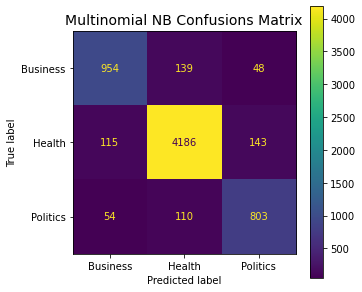

In [ ]:
# NB model
model = MultinomialNB(alpha=1e-8)

model_, nb_score, y_pred = train_evaluate_models(model,
                                                X_train_, X_test_,
                                                y_train_, y_test_,
                                                name='Multinomial NB', cm_plot=True)


### Bagging

Bagging Multinomial NB Training...
Bagging Multinomial NB F1-score 90.72%
------------------------------
Classification Reports...

              precision    recall  f1-score   support

    Business       0.86      0.82      0.84      1141
      Health       0.94      0.94      0.94      4444
    Politics       0.81      0.84      0.82       967

    accuracy                           0.91      6552
   macro avg       0.87      0.87      0.87      6552
weighted avg       0.91      0.91      0.91      6552



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


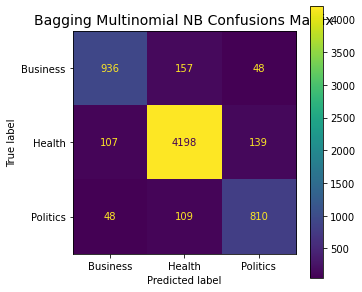

In [ ]:
nb_bagg_clf = BaggingClassifier(base_estimator=model_, n_estimators=5, random_state=42, n_jobs=-1)

model, nb_bagg_score, y_pred = train_evaluate_models(nb_bagg_clf,
                                                    X_train_, X_test_,
                                                    y_train_, y_test_,
                                                    name='Bagging Multinomial NB', cm_plot=True)

CV Score...
Accuracy: 0.9086541032354646


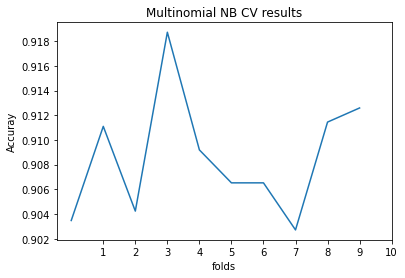

In [ ]:
# cv
nb_res = evaluate_CV(model_, n_folds=10, name='Multinomial NB')

## 1.3 KNN

KNN Training...
KNN F1-score 81.21%
------------------------------
Classification Reports...

              precision    recall  f1-score   support

    Business       0.88      0.40      0.55      1141
      Health       0.80      0.99      0.88      4444
    Politics       0.92      0.47      0.62       967

    accuracy                           0.81      6552
   macro avg       0.87      0.62      0.69      6552
weighted avg       0.83      0.81      0.79      6552



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


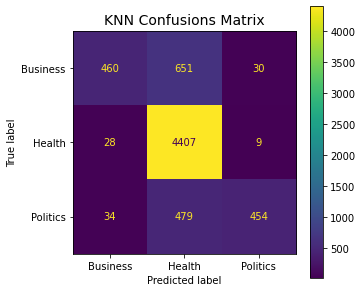

In [ ]:
# KNN model
model = KNeighborsClassifier(n_neighbors=5)

model_, knn_score, y_pred = train_evaluate_models(model,
                                                X_train_, X_test_,
                                                y_train_, y_test_,
                                                name='KNN', cm_plot=True)

In [ ]:
# bagging
knn_bagg_clf = BaggingClassifier(base_estimator=model_, n_estimators=5, random_state=42)

model, knn_bagg_score, y_pred = train_evaluate_models(knn_bagg_clf,
                                                        X_train_, X_test_,
                                                        y_train_, y_test_,
                                                        name='Bagging KNN', cm_plot=False)

Bagging KNN Training...
Bagging KNN F1-score 80.24%
------------------------------
Classification Reports...

              precision    recall  f1-score   support

    Business       0.88      0.36      0.52      1141
      Health       0.79      0.99      0.88      4444
    Politics       0.92      0.44      0.60       967

    accuracy                           0.80      6552
   macro avg       0.86      0.60      0.66      6552
weighted avg       0.82      0.80      0.77      6552



CV Score...
Accuracy: 0.8023501751851605


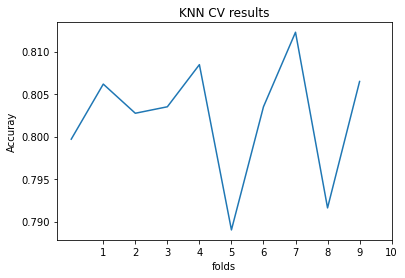

In [ ]:
# cv
knn_res = evaluate_CV(model_, n_folds=10, name='KNN')

## 1.4 SVM

SVM Training...
SVM F1-score 95.59%
------------------------------
Classification Reports...

              precision    recall  f1-score   support

    Business       0.96      0.90      0.93      1141
      Health       0.95      0.99      0.97      4444
    Politics       0.97      0.87      0.92       967

    accuracy                           0.96      6552
   macro avg       0.96      0.92      0.94      6552
weighted avg       0.96      0.96      0.96      6552



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


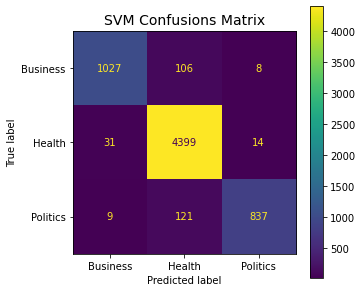

In [ ]:
# # SVM model
model = SVC(C=1., kernel='linear')

model_, svm_score, y_pred = train_evaluate_models(model,
                                           X_train_, X_test_,
                                            y_train_, y_test_,
                                           name='SVM', cm_plot=True)

In [ ]:
# # bagging
svm_bagg_clf = BaggingClassifier(base_estimator=model_, n_estimators=5, random_state=42)

model, svm_bagg_score, svm_pred = train_evaluate_models(svm_bagg_clf,
                                                        X_train_, X_test_,
                                                        y_train_, y_test_,
                                                        name='Bagging SVM', cm_plot=False)

In [ ]:
# # cv
svm_res = evaluate_CV(model_, n_folds=10, name='SVM')

## 1.5 Logistic Regressions

In [ ]:
# LR model
model = LogisticRegression(max_iter=1e3)

model_, lr_score, y_pred = train_evaluate_models(model,
                                         X_train_, X_test_,
                                         y_train_, y_test_,
                                         name='Logistic Regressions', cm_plot=False)

In [ ]:
# bagging
lr_bagg_clf = BaggingClassifier(base_estimator=model_, n_estimators=5, random_state=42)

model, lr_bagg_score, y_pred = train_evaluate_models(lr_bagg_clf,
                                                    X_train_, X_test_,
                                                    y_train_, y_test_,
                                                    name='Bagging Logistic Regressions', cm_plot=False)

In [ ]:
# cv
lr_res = evaluate_CV(model_, n_folds=10, name='Logistic Regressions')

## 1.6 CLFs Comparison

In [ ]:
clfs = ['LSTM', 'Naive Bayes', 'KNN','SVM', 'LogReg.']
scores = [lstm_score, nb_score, knn_score, svm_score, lr_score]
cv_res = [0, nb_res, knn_res, svm_res, lr_res]
res_bagg = [0, nb_bagg_score, knn_bagg_score, svm_bagg_score, lr_bagg_score]

topic_scores = pd.DataFrame(scores, index=clfs, columns=['F1-Score'])
topic_scores['CV-Score'] = cv_res
topic_scores['BAGGING-Score'] = res_bagg


topic_scores

In [ ]:
def plot_comparision(acc_df, column, par='Topic'):
    acc_df.plot(kind='bar', y=[f'{column}'], figsize=(11, 5), alpha=0.7);

    for i in range(len(acc_df)):
        text = '{:.2f}%'.format(acc_df[f'{column}'][i] * 100)
        y_val = round(acc_df[f'{column}'][i], 4)
        plt.text(i-0.15, y_val, text, color='r', alpha=1, fontsize=15);

    plt.title(f'{par} CLFs Scores Comparision.', fontsize=18);
    plt.xticks(rotation=0);
    plt.yticks(np.arange(0, 1.1, 0.2));
    plt.xlabel('Models', fontsize=14);
    plt.ylabel(f'{column}', fontsize=14);
    plt.legend([]);
    plt.savefig(f'{par}_clfs_comparision.png')
    plt.show()

In [ ]:
plot_comparision(topic_scores, 'F1-Score')

In [ ]:
topic_scores.plot(kind='bar', figsize=(11, 5), alpha=0.7)
plt.title(f'CLFs Single vs Cross-Valid vs Bagging Scores Comparision.', fontsize=18);
plt.xticks(rotation=30);

plt.show()

# **2. Sentiment (Target)**

## Target Preprocessing

In [ ]:
target_col = 'sentiment(Target)'

classes = sorted(tweets[target_col].unique())
n_classes = len(classes)

classes

['Negative', 'Neutral', 'Positive']

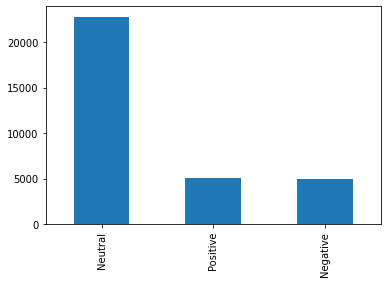

In [ ]:
tweets[target_col].value_counts().plot(kind='bar');

In [ ]:
# One Hot Encode Y values:
le = LabelEncoder()
y = le.fit_transform(tweets[target_col].values)
y.shape

(32760,)

### Features Preprocessing

In [ ]:
text = tweets['Text']
text.shape

(32760,)

In [ ]:
count_vect = CountVectorizer(stop_words = sw)
X = count_vect.fit_transform(text)

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X)
X_tfidf.shape

(32760, 86321)

In [ ]:
# Over Sampling
from imblearn.over_sampling import SMOTE
oversample = SMOTE()

X_, y_ = oversample.fit_resample(X_tfidf, y)

X_.shape, y_.shape

((68397, 86321), (68397,))

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
oversample=RandomUnderSampler(random_state=0)
oversample.fit(X, y)
X_, y_  = oversample.fit_resample(X_tfidf, y)
X_.shape, y_.shape

((14787, 86321), (14787,))

In [ ]:
np.unique(y, return_counts=True)

(array([0, 1, 2]), array([ 4929, 22799,  5032]))

In [ ]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size=0.2, random_state=42, stratify=y_)
#X_train_, X_test_, y_train_, y_test_ = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

## 2.1 Naive Bayes

Sentiment Multinomial NB Training...
Sentiment Multinomial NB F1-score 92.53%
------------------------------
Classification Reports...

              precision    recall  f1-score   support

    Negative       0.91      0.99      0.95      4560
     Neutral       0.98      0.79      0.88      4560
    Positive       0.90      0.99      0.95      4560

    accuracy                           0.93     13680
   macro avg       0.93      0.93      0.92     13680
weighted avg       0.93      0.93      0.92     13680



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


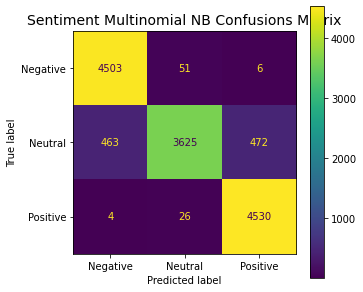

In [ ]:
# NB model
model = MultinomialNB(alpha=1e-8)

model_, nb_score, y_pred = train_evaluate_models(model,
                                         X_train_, X_test_,
                                         y_train_, y_test_,
                                         name='Sentiment Multinomial NB', cm_plot=True)


### Bagging

Sentiment Bagging Multinomial NB Training...
Sentiment Bagging Multinomial NB F1-score 91.29%
------------------------------
Classification Reports...

              precision    recall  f1-score   support

    Negative       0.89      0.99      0.94      4560
     Neutral       0.98      0.76      0.86      4560
    Positive       0.89      0.99      0.94      4560

    accuracy                           0.91     13680
   macro avg       0.92      0.91      0.91     13680
weighted avg       0.92      0.91      0.91     13680



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


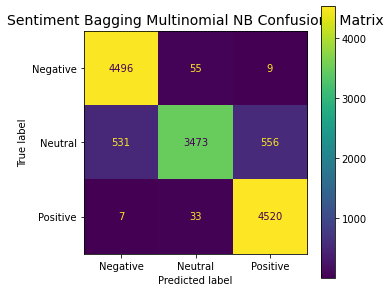

In [ ]:
nb_bagg_clf = BaggingClassifier(base_estimator=model_, n_estimators=5, random_state=42, n_jobs=-1)

model, nb_bagg_score, y_pred = train_evaluate_models(nb_bagg_clf,
                                                    X_train_, X_test_,
                                                    y_train_, y_test_,
                                                    name='Sentiment Bagging Multinomial NB', cm_plot=True)

CV Score...
Accuracy: 0.9191659792301996


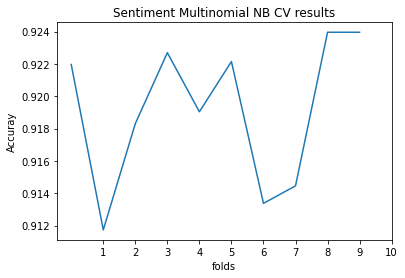

In [ ]:
# cv
nb_res = evaluate_CV(model_, n_folds=10, name='Sentiment Multinomial NB')

## 2.2 KNN

Sentiment KNN Training...
Sentiment KNN F1-score 70.36%
------------------------------
Classification Reports...

              precision    recall  f1-score   support

    Negative       0.64      0.99      0.78      4560
     Neutral       0.97      0.14      0.24      4560
    Positive       0.75      0.98      0.85      4560

    accuracy                           0.70     13680
   macro avg       0.79      0.70      0.62     13680
weighted avg       0.79      0.70      0.62     13680



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


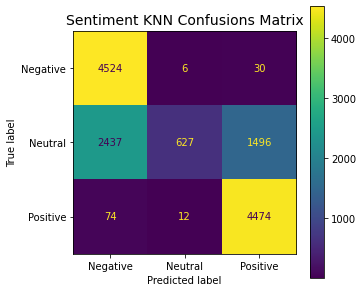

In [ ]:
# KNN model
model = KNeighborsClassifier(n_neighbors=5)

model_, knn_score, y_pred = train_evaluate_models(model,
                                           X_train_, X_test_,
                                           y_train_, y_test_,
                                           name='Sentiment KNN', cm_plot=True)

In [ ]:
# bagging
knn_bagg_clf = BaggingClassifier(base_estimator=model_, n_estimators=5, random_state=42)

model, knn_bagg_score, y_pred = train_evaluate_models(knn_bagg_clf,
                                                    X_train_, X_test_,
                                                    y_train_, y_test_,
                                                    name='Sentiment Bagging KNN', cm_plot=False)

Sentiment Bagging KNN Training...
Sentiment Bagging KNN F1-score 71.48%
------------------------------
Classification Reports...

              precision    recall  f1-score   support

    Negative       0.68      0.99      0.81      4560
     Neutral       0.98      0.17      0.29      4560
    Positive       0.72      0.99      0.83      4560

    accuracy                           0.71     13680
   macro avg       0.79      0.71      0.64     13680
weighted avg       0.79      0.71      0.64     13680



CV Score...
Accuracy: 0.6941902699881672


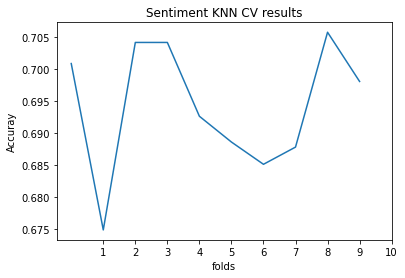

In [ ]:
# cv
knn_res = evaluate_CV(model_, n_folds=10, name='Sentiment KNN')

## 2.3 SVM

Sentiment SVM Training...
Sentiment SVM F1-score 91.20%
------------------------------
Classification Reports...

              precision    recall  f1-score   support

    Negative       0.99      0.88      0.93      4560
     Neutral       0.80      0.98      0.88      4560
    Positive       0.99      0.88      0.93      4560

    accuracy                           0.91     13680
   macro avg       0.93      0.91      0.91     13680
weighted avg       0.93      0.91      0.91     13680



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


ValueError: ignored

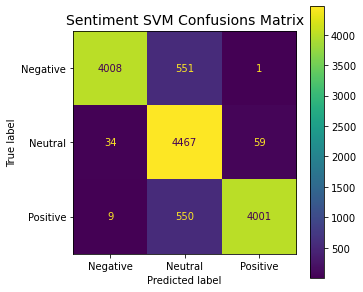

In [ ]:
# # SVM model
model = SVC()

model_, svm_score = train_evaluate_models(model,
                                           X_train_, X_test_,
                                           y_train_, y_test_,
                                           name='Sentiment SVM', cm_plot=True)

In [ ]:
# # bagging
svm_bagg_clf = BaggingClassifier(base_estimator=model, n_estimators=5, random_state=42)

model, svm_bagg_score, svm_pred = train_evaluate_models(svm_bagg_clf,
                                                        X_train_, X_test_,
                                                        y_train_, y_test_,
                                                        name='Sentiment Bagging SVM', cm_plot=False)

Sentiment Bagging SVM Training...


In [ ]:
# # cv
svm_res = evaluate_CV(model, n_folds=10, name='Sentiment SVM')

## 2.4 Logistic Regression

In [ ]:
# LR model
model = LogisticRegression(max_iter=1e3)

model_, lr_score, y_pred = train_evaluate_models(model,
                                         X_train_, X_test_,
                                         y_train_, y_test_,
                                         name='Sentiment Logistic Regressions', cm_plot=True)

Sentiment Logistic Regressions Training...


In [ ]:
# bagging
lr_bagg_clf = BaggingClassifier(base_estimator=model_, n_estimators=5, random_state=42)

model, lr_bagg_score, y_pred = train_evaluate_models(lr_bagg_clf,
                                                    X_train_, X_test_,
                                                    y_train_, y_test_,
                                                    name='Sentiment Bagging Logistic Regressions', cm_plot=False)

Sentiment Bagging Logistic Regressions Training...


KeyboardInterrupt: ignored

In [ ]:
# cv
lr_res = evaluate_CV(model_, n_folds=10, name='Sentiment Logistic Regressions')

## 2.5 Sentiment CLFs Comparison

In [ ]:
clfs = ['Naive Bayes', 'KNN','SVM', 'LogReg.']
scores = [nb_score, knn_score, svm_score, lr_score]
cv_res = [nb_res, knn_res, svm_res, lr_res]
res_bagg = [nb_bagg_score, knn_bagg_score, svm_bagg_score, lr_bagg_score]

sent_scores = pd.DataFrame(scores, index=clfs, columns=['F1-Score'])
sent_scores['CV-Score'] = cv_res
sent_scores['BAGGING-Score'] = res_bagg

sent_scores

In [ ]:
plot_comparision(sent_scores, 'F1-Score', 'Sentiment')

In [ ]:
sent_scores[['BAGGING-Score', 'CV-Score']].plot(kind='bar', figsize=(11, 5), alpha=0.7)
plt.title(f'Sentiment CLFs Cross Valid vs Bagging Scores Comparision.', fontsize=18);
plt.xticks(rotation=30);

plt.show()